# PUR-Check: Automatisierte Zellanalyse mehrerer Bilder von Polyurethan-Hartschaumproben

### Initialisierung von Bibliotheken

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import imagej
import scyjava as sj
import numpy as np
import random
import time
import pandas as pd

# ImageJ initialisieren
ij = imagej.init('sc.fiji:fiji')
print(f"ImageJ2 version: {ij.getVersion()}")

ImageJ2 version: 2.15.0/1.54f


### Datenvorbereitung und Bildverarbeitungsprozess für Watershed-Analyse

In [13]:
# Pfade definieren
image_folder_path = r'D:\Studium\Master\Masterarbeit\Code\DL\02_Cropped Images'
watershed_folder_path = os.path.join(image_folder_path, 'watershed_images')

# Erstellen des neuen Unterordners für Watershed-Bilder
os.makedirs(watershed_folder_path, exist_ok=True)

# Initialisierung der Variablen für die Gesamtergebnisse
total_cell_areas_mm2 = []
total_cell_diameters_mm = []
total_wall_thicknesses = []
processed_images_count = 0
total_image_area_mm2 = 0  # Variable für die Gesamtbildfläche

# Liste der bearbeiteten Bilder
processed_images = []

# Pfade zu den Ergebnisse-CSV-Dateien
cell_measurements_file = 'zellmessungen.csv'
wall_thicknesses_file = 'wanddicken.csv'

# Alte Ergebnisse löschen, falls vorhanden
if os.path.exists(cell_measurements_file):
    os.remove(cell_measurements_file)
if os.path.exists(wall_thicknesses_file):
    os.remove(wall_thicknesses_file)

# Umrechnungsfaktor von Pixel in mm definieren
PIXEL_TO_MM = 0.025

# Startzeit festhalten
start_time = time.time()

def process_image(image_path):
    # Bild laden
    img_crop = cv2.imread(image_path)

    # Bild in eine binäre Maske konvertieren
    gray_image = cv2.cvtColor(img_crop, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    inverted_binary_mask = cv2.bitwise_not(binary_mask)

    # Invertierte binäre Maske in ein ImageJ-Objekt konvertieren
    imagej_object = ij.py.to_imageplus(inverted_binary_mask)
    imagej_object.updateAndDraw()

    # Prozessor des Bildes erhalten
    ip = imagej_object.getProcessor()

    # EDM importieren und Watershed-Operation durchführen
    EDM = sj.jimport('ij.plugin.filter.EDM')
    edm = EDM()

    # Überprüfen, ob das Bild binär ist
    if not ip.isBinary():
        ij.IJ().log("8-bit binary image (0 and 255) required.")
    else:
        edm.setup("watershed", None)
        edm.run(ip)

    # Bild nach Watershed temporär speichern
    temp_output_path = os.path.join(watershed_folder_path, f"{os.path.splitext(os.path.basename(image_path))[0]}_watershed.tif")
    ij.IJ().saveAs(imagej_object, "Tiff", temp_output_path)

    # Bild erneut öffnen
    img_Watershed_binary = cv2.imread(temp_output_path, cv2.IMREAD_UNCHANGED)

    # Konturen finden
    contours, _ = cv2.findContours(img_Watershed_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return img_crop, img_Watershed_binary, contours

# Durch alle Bilder im Ordner iterieren
for filename in os.listdir(image_folder_path):
    if filename.endswith(".tif"):
        image_path = os.path.join(image_folder_path, filename)
        img_crop, img_Watershed_binary, contours = process_image(image_path)

        # Flächen der Zellen berechnen
        cell_areas_px = [cv2.contourArea(cnt) for cnt in contours]
        cell_areas_mm2 = [area * (PIXEL_TO_MM ** 2) for area in cell_areas_px]  # Umrechnung von Pixel in mm²
        total_cell_areas_mm2.extend(cell_areas_mm2)

        # Durchmesser der Zellen berechnen
        cell_diameters_mm = [np.sqrt(4 * area / np.pi) for area in cell_areas_mm2]  # Umrechnung der Fläche in Durchmesser
        total_cell_diameters_mm.extend(cell_diameters_mm)

        # Distanztransformation anwenden, um Wanddicken zu berechnen
        mask = cv2.bitwise_not(img_Watershed_binary)
        dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 3)
        wall_thicknesses = dist_transform[img_Watershed_binary == 0]  # Wanddicke nur an bestimmten Stellen messen
        total_wall_thicknesses.extend(wall_thicknesses * PIXEL_TO_MM)  # Umrechnung von Pixel in mm

        # Anzahl der bearbeiteten Bilder erhöhen
        processed_images_count += 1
        processed_images.append((img_crop, img_Watershed_binary, contours))

        # Gesamtfläche des Bildes berechnen
        total_area_px = img_Watershed_binary.shape[0] * img_Watershed_binary.shape[1]
        total_area_mm2 = total_area_px * (PIXEL_TO_MM ** 2)  # Umrechnung von Pixel in mm²
        total_image_area_mm2 += total_area_mm2  # Gesamtfläche aller Bilder addieren

# Endzeit festhalten
end_time = time.time()

# Ergebnisse in separaten CSV-Dateien speichern

# Zellmessungen speichern
cell_df = pd.DataFrame({
    'cell_areas_mm2': total_cell_areas_mm2,
    'cell_diameters_mm': total_cell_diameters_mm
})
cell_df.to_csv(cell_measurements_file, index=False)

# Wanddicken speichern
wall_df = pd.DataFrame({
    'wall_thicknesses_mm': total_wall_thicknesses
})
wall_df.to_csv(wall_thicknesses_file, index=False)

# Verstrichene Zeit berechnen
elapsed_time = end_time - start_time
elapsed_minutes = int(elapsed_time // 60)
elapsed_seconds = elapsed_time % 60

print(f"Anzahl der bearbeiteten Bilder: {processed_images_count}")
print(f"Verstrichene Zeit: {elapsed_minutes} Minuten und {elapsed_seconds:.2f} Sekunden")

Anzahl der bearbeiteten Bilder: 1242
Verstrichene Zeit: 1 Minuten und 52.95 Sekunden


### Berechnung und Ausgabe der Analyseergebnisse

In [23]:
# Gesamtergebnisse berechnen
average_cell_area_mm2 = np.mean(total_cell_areas_mm2) if total_cell_areas_mm2 else 0  # Durchschnittliche Zellenfläche
largest_cell_area_mm2 = np.max(total_cell_areas_mm2) if total_cell_areas_mm2 else 0  # Größte Zellenfläche
mean_cell_diameter_mm = np.mean(total_cell_diameters_mm) if total_cell_diameters_mm else 0  # Durchschnittlicher Zellen-Durchmesser
max_cell_diameter_mm = np.max(total_cell_diameters_mm) if total_cell_diameters_mm else 0  # Größter Zellen-Durchmesser
mean_wall_thickness = np.mean(total_wall_thicknesses) if total_wall_thicknesses else 0  # Durchschnittliche Wanddicke
max_wall_thickness = np.max(total_wall_thicknesses) if total_wall_thicknesses else 0  # Maximale Wanddicke

# Verhältnis der Zellenfläche zur Gesamtfläche aller Bilder berechnen
total_cell_area_mm2 = sum(total_cell_areas_mm2)  # Gesamte Zellenfläche
cell_area_ratio_total = total_cell_area_mm2 / total_image_area_mm2 if total_image_area_mm2 else 0  # Verhältnis der Zellenfläche zur Gesamtbildfläche

# Anforderungen nach EN 253 überprüfen
en253_requirement = 0.1 <= mean_cell_diameter_mm <= 0.5  # Prüfen, ob der mittlere Durchmesser im zulässigen Bereich liegt

# Ergebnisse ausgeben
print(f"Mittlere Zellenfläche: {average_cell_area_mm2:.4f} mm²")
print(f"Größte Zellenfläche: {largest_cell_area_mm2:.4f} mm²")
print(f"Durchmesser der mittleren Zelle: {mean_cell_diameter_mm:.2f} mm")
print(f"Durchmesser der größten Zelle: {max_cell_diameter_mm:.2f} mm")
print(f"Verhältnis der gesamten Zellenfläche zur Gesamtfläche aller Bilder: {cell_area_ratio_total*100:.2f}%")
if en253_requirement:
    print("Der Durchmesser der mittleren Zelle erfüllt die Anforderungen nach EN 253.")
else:
    print("Der Durchmesser der mittleren Zelle erfüllt NICHT die Anforderungen nach EN 253.")
print(f"Mittlere Wanddicke: {mean_wall_thickness:.4f} mm")
print(f"Maximale Wanddicke: {max_wall_thickness:.4f} mm")

Mittlere Zellenfläche: 0.0454 mm²
Größte Zellenfläche: 5.3250 mm²
Durchmesser der mittleren Zelle: 0.21 mm
Durchmesser der größten Zelle: 2.60 mm
Verhältnis der gesamten Zellenfläche zur Gesamtfläche aller Bilder: 54.43%
Der Durchmesser der mittleren Zelle erfüllt die Anforderungen nach EN 253.
Mittlere Wanddicke: 0.0322 mm
Maximale Wanddicke: 0.3248 mm


### Visualisierung von Zufallsbildern mit markierten Konturen

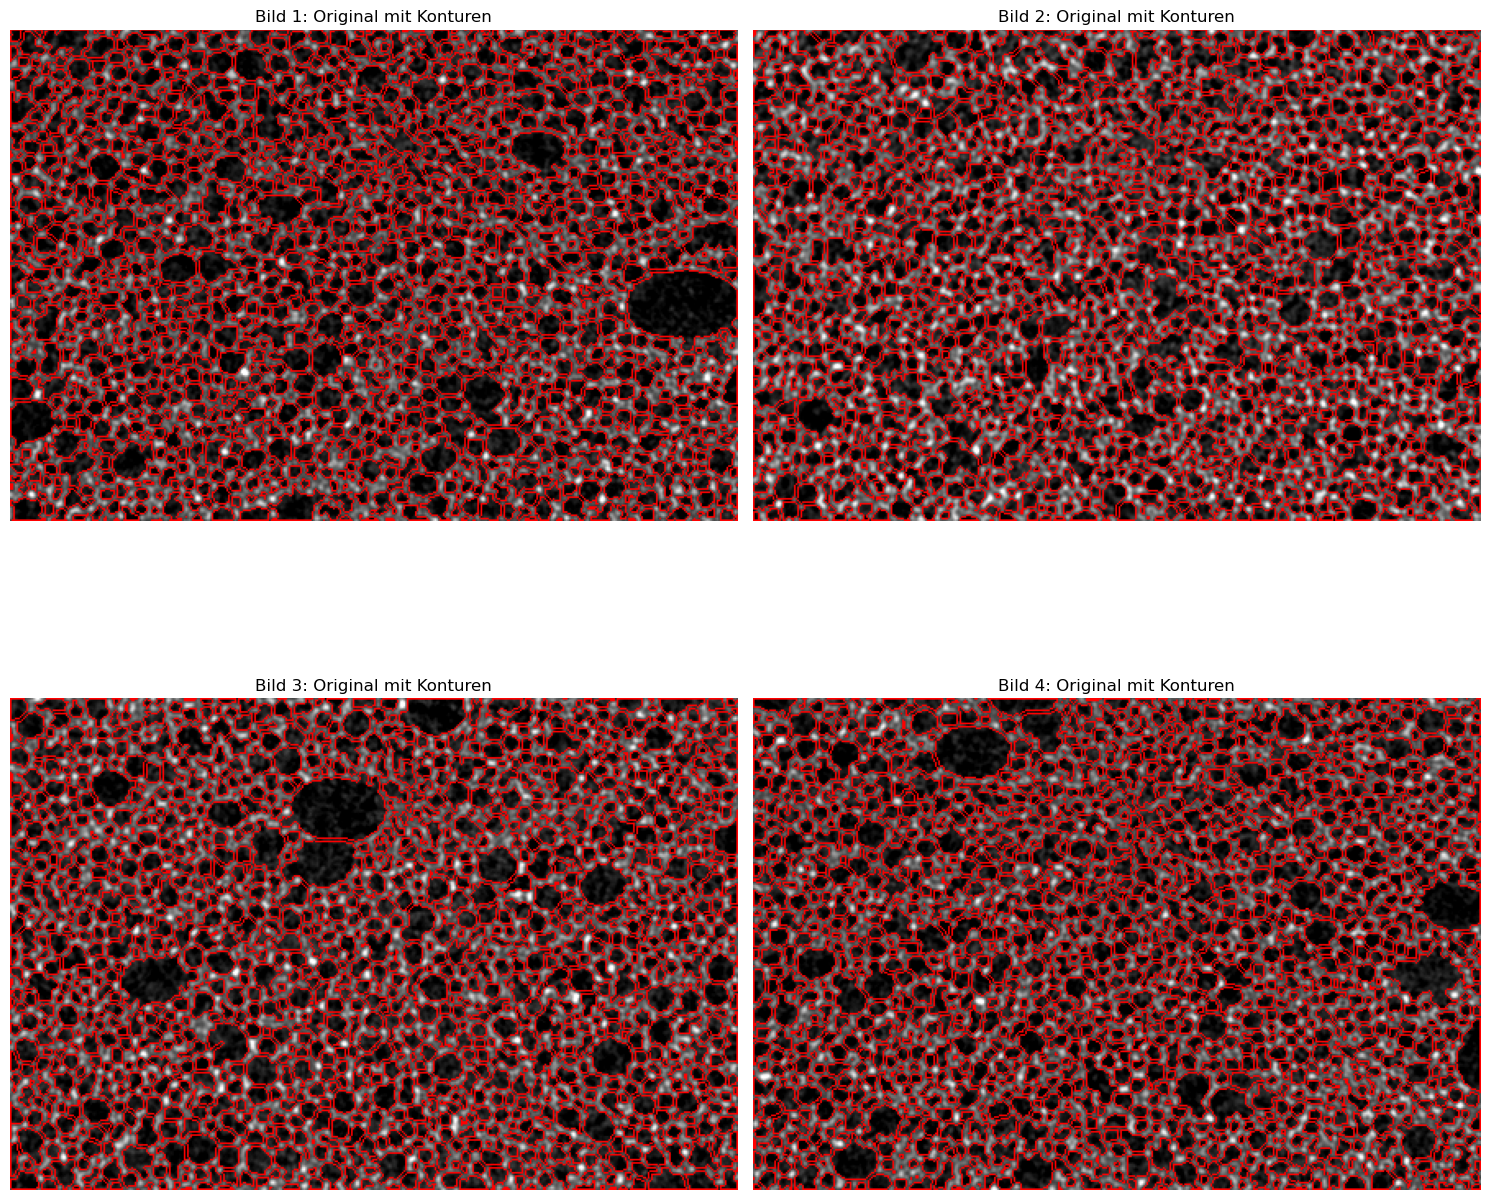

In [57]:
# Vier zufällige Bilder auswählen und anzeigen
if processed_images:
    random_images = random.sample(processed_images, min(4, len(processed_images)))

    # Dynamische Größe für das Raster berechnen, damit keine großen Lücken entstehen
    fig, axes = plt.subplots(2, 2, figsize=(min(15, 5 * len(random_images)), min(15, 5 * len(random_images))))
    axes = axes.ravel()  

    for i, (original_img, watershed_img, contours) in enumerate(random_images):
        # Konturen auf dem Originalbild zeichnen
        contour_img = original_img.copy()
        cv2.drawContours(contour_img, contours, -1, (0, 0, 255), 1)  # Konturen in Rot zeichnen

        # Bild anzeigen
        axes[i].imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
        axes[i].set_title(f"Bild {i + 1}: Original mit Konturen")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

### Histogramm für Zellendurchmesser

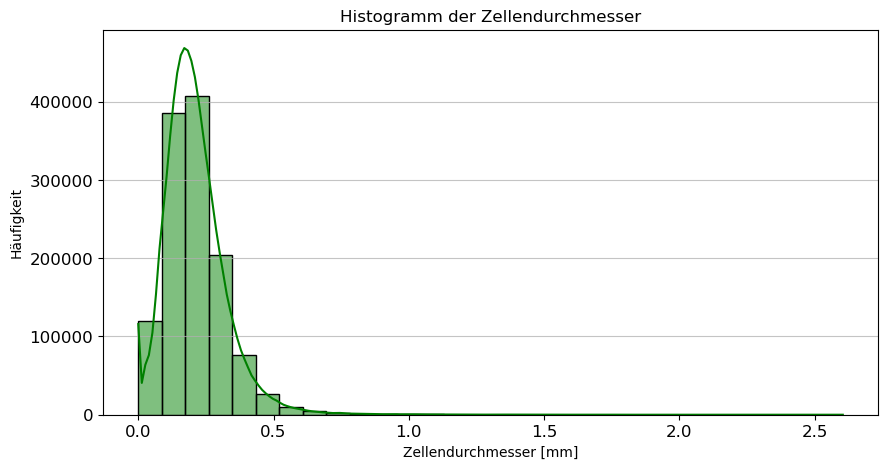

In [7]:
# Histogramm für Zellendurchmesser
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.histplot(total_cell_diameters_mm, bins=30, kde=True, color='green', edgecolor='black')
plt.xlabel('Zellendurchmesser [mm]')
plt.ylabel('Häufigkeit')
plt.title('Histogramm der Zellendurchmesser')
plt.grid(axis='y', alpha=0.75)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Weibull-Verteilung für Wandstärke

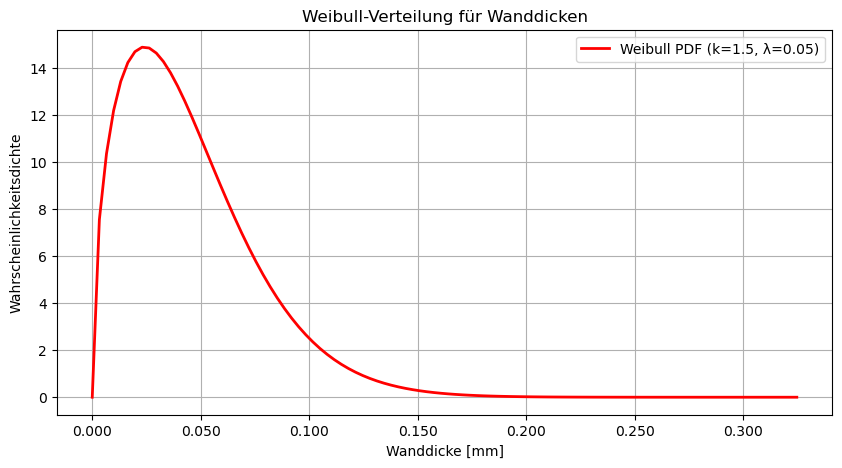

In [8]:
# Weibull-Verteilung für Wandstärke
from scipy.stats import weibull_min
k = 1.5  # Formparameter
lambda_ = 0.05  # Skalenparameter
max_wall_thickness_value = max(total_wall_thicknesses)
x = np.linspace(0, max_wall_thickness_value, 100)

plt.figure(figsize=(10, 5))
plt.plot(x, weibull_min.pdf(x, k, scale=lambda_), 'r-', lw=2, label=f'Weibull PDF (k={k}, λ={lambda_})')
plt.title('Weibull-Verteilung für Wanddicken')
plt.xlabel('Wanddicke [mm]')
plt.ylabel('Wahrscheinlichkeitsdichte')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.3f}".format(x)))
plt.legend()
plt.grid(True)
plt.show()